This notebook contains differential expression and GO-term & pathway enrichment analysis of the Neuronal differention patient dataset.

In [1]:
import scanpy as sc
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
from gprofiler import GProfiler
import batchglm
import diffxpy.api as de
import patsy as pat
import logging, warnings
from batchglm.pkg_constants import TF_CONFIG_PROTO

/home/icb/malte.luecken/anaconda3/envs/sc-tutorial/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/icb/malte.luecken/anaconda3/envs/sc-tutorial/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/icb/malte.luecken/anaconda3/envs/sc-tutorial/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)]

In [2]:
plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.verbosity = 3
#sc.set_figure_params(dpi=200, dpi_save=300)
sc.logging.print_versions()
de.__version__

logging.getLogger("tensorflow").setLevel(logging.ERROR)
logging.getLogger("batchglm").setLevel(logging.INFO)
logging.getLogger("diffxpy").setLevel(logging.INFO)

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 35)
warnings.filterwarnings("ignore", category=DeprecationWarning, module="tensorflow")

scanpy==1.4.3+116.g0075c62 anndata==0.6.22.post2.dev80+g72c2bde umap==0.3.9 numpy==1.17.2 scipy==1.3.0 pandas==0.24.1 scikit-learn==0.21.3 statsmodels==0.10.0rc2 python-igraph==0.7.1 louvain==0.6.1


'v0.6.1'

In [3]:
#Set number of threads
TF_CONFIG_PROTO.inter_op_parallelism_threads = 1
TF_CONFIG_PROTO.intra_op_parallelism_threads = 12


In [4]:
#User inputs
folder = '/storage/groups/ml01/workspace/malte.luecken/2019_wurst_demuxlet/Main_study/'

adata_stripped_diffxpy = '/storage/groups/ml01/workspace/malte.luecken/2019_wurst_demuxlet/Main_study/processed_data/ipsc_ipd_patients_nsc_cell_fate_labs.h5ad'

adata_final = '/storage/groups/ml01/workspace/malte.luecken/2019_wurst_demuxlet/Main_study/processed_data/ipsc_ipd_patients_final.h5ad'

de_output_pickle = '/storage/groups/ml01/workspace/malte.luecken/2019_wurst_demuxlet/Main_study/processed_data/ipsc_ipd_patients_de_results_NSC_root_diffxpy_sf.pkl'

de_output_pickle_clusts = '/storage/groups/ml01/workspace/malte.luecken/2019_wurst_demuxlet/Main_study/processed_data/ipsc_ipd_patients_de_results_NSC_root_clusts_diffxpy_sf.pkl'

de_output_base = '/storage/groups/ml01/workspace/malte.luecken/2019_wurst_demuxlet/Main_study/processed_data/ipsc_ipd_patients_sf_de_results_NSC_root'

enrich_output_base = '/storage/groups/ml01/workspace/malte.luecken/2019_wurst_demuxlet/Main_study/processed_data/ipsc_ipd_patients_sf_enrich_results_NSC_root'

# Read the data

In [5]:
lab_adata = sc.read(adata_stripped_diffxpy)

In [6]:
adata = sc.read(adata_final)

In [7]:
adata

AnnData object with n_obs × n_vars = 30557 × 24920 
    obs: 'Demux_state', 'Donor', 'Lane', 'Number of genes', 'Total counts', 'age', 'condition', 'donor', 'gender', 'log_counts', 'mt_frac', 'n_counts', 'n_genes', 'size_factors', 'total_counts', 'years_of_illness', 'S_score', 'G2M_score', 'phase', 'louvain_r1', 'louvain_r0.5', 'louvain_r0.2', 'score', 'louvain_r0.2_0_sub', 'louvain_r0.2_0_4_sub', 'louvain_r0.2_0_3_sub', 'dpt_pseudotime', 'louvain_r0.2_noCC', 'louvain_final', 'Ferroptosis_pos_raw', 'Ferroptosis_pos_corr', 'Ferroptosis_neg_raw', 'Ferroptosis_neg_corr', 'Apoptosis_pos_raw', 'Apoptosis_pos_corr', 'Apoptosis_neg_raw', 'Apoptosis_neg_corr', 'Necroptosis_pos_raw', 'Necroptosis_pos_corr', 'Autophagy_pos_raw', 'Autophagy_pos_corr', 'Pathanatos_pos_raw', 'Pathanatos_pos_corr', 'louvain_final_abbrev'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Donor_colors', 'condition_colors', 'gender_colors', 'louvain', 'louvain_final_abbrev_colors', 'louva

## Transfer labels

In [8]:
adata.obs_names = [cell.split('-')[0] for cell in adata.obs_names]
lab_adata.obs_names = [cell.split(':')[1] for cell in lab_adata.obs_names]

In [9]:
adata.obs['NSC_root_clusts'] = [lab_adata.obs['NSC_root_cell'][cell] if cell in lab_adata.obs_names else 'False' for cell in adata.obs_names]
adata.obs['NSC_root_clusts'].value_counts()

False        29705
NSC1 fate      514
NSC2 fate      338
Name: NSC_root_clusts, dtype: int64

In [10]:
adata.obs['NSC_root_cell'] = [lab.startswith('NSC') for lab in adata.obs['NSC_root_clusts']]

In [11]:
adata.obs['NSC_root_cell'].value_counts()

False    29705
True       852
Name: NSC_root_cell, dtype: int64

# Check the data

In [12]:
np.mean(adata.layers['counts'].astype(int) != adata.layers['counts'])

0.0

Counts are actually all integer counts.

In [13]:
adata.obs.condition.value_counts()

Parkinson    18887
Control      11670
Name: condition, dtype: int64

In [14]:
adata.obs.groupby(['NSC_root_cell'])['condition'].value_counts()

NSC_root_cell  condition
False          Parkinson    18299
               Control      11406
True           Parkinson      588
               Control        264
Name: condition, dtype: int64

In [15]:
adata.obs.groupby(['NSC_root_clusts'])['condition'].value_counts()

NSC_root_clusts  condition
False            Parkinson    18299
                 Control      11406
NSC1 fate        Parkinson      340
                 Control        174
NSC2 fate        Parkinson      248
                 Control         90
Name: condition, dtype: int64

Note:
- General imbalance between Parkinson and control cell numbers
- imbalance strongly represented in 'NSC (Shh)', 'NSC (Shh, G2M)', 'Glial precursors (myelinating)', and 'immature neurons' clusters
- more control cells than expected in 'NCSC (low MT)' and 'NSC (early)'

# DE Testing

Calculate DE genes per cluster.

In [16]:
de_results = dict()

In [17]:
de.utils.preview_coef_names(
    sample_description=adata.obs,
    formula="~1+condition+Donor", 
)

array(['Intercept', 'condition[T.Parkinson]', 'Donor[T.UKERi1JF-R1-018]',
       'Donor[T.UKERi82A-R1-002]', 'Donor[T.UKERi88H-R1-002]',
       'Donor[T.UKERiAY6-R1-003]', 'Donor[T.UKERiC99-R1-007]',
       'Donor[T.UKERiG3G-R1-039]', 'Donor[T.UKERiJ2C-R1-015]',
       'Donor[T.UKERiM89-R1-005]', 'Donor[T.UKERiO3H-R1-005]',
       'Donor[T.UKERiPX7-R1-001]', 'Donor[T.UKERiR66-R1-007]'],
      dtype='<U24')

In [18]:
# Test the new "coarse" clusters quickly
for clust in [True]:
    adata_tmp = adata[adata.obs['NSC_root_cell'] == clust,:].copy()

    print(f'In cluster {clust}:')
    print(adata_tmp.obs.condition.value_counts())

    # Filter out genes to reduce multiple testing burden
    sc.pp.filter_genes(adata_tmp, min_cells=50)
    print(f'Testing {adata_tmp.n_vars} genes...')
    print("")
    
    test_tmp = de.test.wald(
    data=adata_tmp.layers['counts'],
    formula_loc="~ 1 + condition + Donor + size_factors",
    as_numeric=['size_factors'],
    coef_to_test=["condition[T.Parkinson]"],
    sample_description=adata_tmp.obs,
    gene_names=adata_tmp.var_names,
    constraints_loc={'Donor':'condition'},
    noise_model='nb',
    dtype="float64"
    )
    
    #Store the results
    de_results[clust] = test_tmp

In cluster True:
Parkinson    588
Control      264
Name: condition, dtype: int64
filtered out 2962 genes that are detectedin less than 50 cells
Testing 21958 genes...



Built constraints: Donor[UKERi1E4-R1-003]+Donor[UKERi1JF-R1-018]+Donor[UKERi82A-R1-002]+Donor[UKERiG3G-R1-039]+Donor[UKERiO3H-R1-005]=0, Donor[UKERi88H-R1-002]+Donor[UKERiAY6-R1-003]+Donor[UKERiC99-R1-007]+Donor[UKERiJ2C-R1-015]+Donor[UKERiM89-R1-005]+Donor[UKERiPX7-R1-001]+Donor[UKERiR66-R1-007]=0



For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

INFO:diffxpy:Fitting model...


In [59]:
# Test the new "coarse" clusters quickly
for clust in [True]:
    adata_tmp = adata[adata.obs['NSC_root_cell'] == clust,:].copy()

    print(f'In cluster {clust}:')
    print(adata_tmp.obs.condition.value_counts())

    # Filter out genes to reduce multiple testing burden
    sc.pp.filter_genes(adata_tmp, min_cells=50)
    print(f'Testing {adata_tmp.n_vars} genes...')
    print("")
    
    test_tmp = de.test.wald(
    data=adata_tmp.layers['counts'],
    formula_loc="~ 1 + condition + Donor + size_factors",
    as_numeric=['size_factors'],
    coef_to_test=["condition[T.Parkinson]"],
    sample_description=adata_tmp.obs,
    gene_names=adata_tmp.var_names,
    constraints_loc={'Donor':'condition'},
    noise_model='nb',
    dtype="float64"
    )
    
    #Store the results
    de_results[clust] = test_tmp

In cluster True:
Parkinson    398
Control      256
Name: condition, dtype: int64
filtered out 3304 genes that are detectedin less than 50 cells
Testing 21616 genes...



Built constraints: Donor[UKERi1JF-R1-018]+Donor[UKERiG3G-R1-039]+Donor[UKERi1E4-R1-003]+Donor[UKERiO3H-R1-005]+Donor[UKERi82A-R1-002]=0, Donor[UKERiJ2C-R1-015]+Donor[UKERiM89-R1-005]+Donor[UKERiC99-R1-007]+Donor[UKERiR66-R1-007]+Donor[UKERiAY6-R1-003]+Donor[UKERiPX7-R1-001]+Donor[UKERi88H-R1-002]=0



For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

INFO:diffxpy:Fitting model...


In [19]:
de_results_clusts = dict()

In [20]:
for clust in ['NSC1 fate', 'NSC2 fate']:
    adata_tmp = adata[adata.obs['NSC_root_clusts'] == clust,:].copy()

    print(f'In cluster {clust}:')
    print(adata_tmp.obs.condition.value_counts())

    # Filter out genes to reduce multiple testing burden
    sc.pp.filter_genes(adata_tmp, min_cells=50)
    print(f'Testing {adata_tmp.n_vars} genes...')
    print("")
    
    test_tmp = de.test.wald(
    data=adata_tmp.layers['counts'],
    formula_loc="~ 1 + condition + Donor + size_factors",
    as_numeric=['size_factors'],
    coef_to_test=["condition[T.Parkinson]"],
    sample_description=adata_tmp.obs,
    gene_names=adata_tmp.var_names,
    constraints_loc={'Donor':'condition'},
    noise_model='nb',
    dtype="float64"
    )
    
    #Store the results
    de_results_clusts[clust] = test_tmp
    

In cluster NSC1 fate:
Parkinson    340
Control      174
Name: condition, dtype: int64
filtered out 4181 genes that are detectedin less than 50 cells


Built constraints: Donor[UKERi1E4-R1-003]+Donor[UKERi1JF-R1-018]+Donor[UKERi82A-R1-002]+Donor[UKERiG3G-R1-039]+Donor[UKERiO3H-R1-005]=0, Donor[UKERi88H-R1-002]+Donor[UKERiAY6-R1-003]+Donor[UKERiC99-R1-007]+Donor[UKERiJ2C-R1-015]+Donor[UKERiM89-R1-005]+Donor[UKERiPX7-R1-001]+Donor[UKERiR66-R1-007]=0


Testing 20739 genes...

INFO:diffxpy:Fitting model...
In cluster NSC2 fate:
Parkinson    248
Control       90
Name: condition, dtype: int64
filtered out 4435 genes that are detectedin less than 50 cells


Built constraints: Donor[UKERi1E4-R1-003]+Donor[UKERi1JF-R1-018]+Donor[UKERi82A-R1-002]+Donor[UKERiG3G-R1-039]+Donor[UKERiO3H-R1-005]=0, Donor[UKERi88H-R1-002]+Donor[UKERiAY6-R1-003]+Donor[UKERiC99-R1-007]+Donor[UKERiJ2C-R1-015]+Donor[UKERiM89-R1-005]+Donor[UKERiPX7-R1-001]+Donor[UKERiR66-R1-007]=0


Testing 20485 genes...

INFO:diffxpy:Fitting model...


# Check some data

In [21]:
de_results[True].summary().sort_values(by='qval', ascending=True).iloc[:10,:]

,gene,pval,qval,log2fc,mean,zero_mean,grad,coef_mle,coef_sd,ll
12011,AP002748.3,0.0,0.0,1.496015,0.124413,False,0.000089,1.496015,0.180055,-327.862627
14344,GIT2,0.0,0.0,4.377684,0.066901,False,0.000019,4.377684,0.208319,-204.361723
9198,TSPYL2,0.0,0.0,2.163913,0.109155,False,0.000383,2.163913,0.215461,-294.141407
14359,PPTC7,0.0,0.0,3.514110,0.066901,False,0.000023,3.514110,0.237335,-206.573551
4173,ARL6,0.0,0.0,4.260801,0.044601,False,0.000093,4.260801,0.257045,-145.614951
543,INPP5B,0.0,0.0,2.596233,0.039906,False,0.000156,2.596233,0.280097,-133.905459
21514,APOBEC3B,0.0,0.0,2.505604,0.109155,False,0.000161,2.505604,0.215026,-287.173924
18481,SUPT4H1,0.0,0.0,2.416264,0.068075,False,0.000189,2.416264,0.243765,-208.744563
12290,PDGFD,0.0,0.0,2.643717,0.031690,False,0.000181,2.643717,0.308889,-115.348065
9213,GNL3L,0.0,0.0,3.032576,0.045775,False,0.000058,3.032576,0.278658,-149.956119


In [22]:
# Test if model did not converger for some genes and some clusters
np.sum(de_results[True].summary()['ll'] == np.float64('-inf'))

0

# Post-process data

In [23]:
de_signif_clusts = dict()
de_full_res_clusts = dict()

for clust in de_results_clusts:
    tmp = de_results_clusts[clust].summary()

    n_infll = np.sum(tmp['ll'] == np.float64('-inf'))
    print(f'There are {n_infll} -inf log likelihood values. Filtering these out now...')
    tmp = tmp.loc[tmp['ll'] != np.float64('-inf')]
    
    n_unconverged = np.sum(tmp['coef_sd'] < 10E-100)
    print(f'There are {n_unconverged} logFC std. dev.s < 10E-100. Filtering these out now...')    
    tmp = tmp.loc[tmp['coef_sd'] > 10E-100]

    #Sort values by q-value
    tmp.sort_values(by='qval', ascending=True, inplace=True)
    
    de_full_res_clusts[clust] = tmp.copy()
    
    #Filter by q-value to get significant DE genes
    tmp_filt = tmp.loc[tmp['qval'] < 0.05]
    de_signif_clusts[clust] = tmp_filt.copy()

There are 0 -inf log likelihood values. Filtering these out now...
There are 16 logFC std. dev.s < 10E-100. Filtering these out now...
There are 0 -inf log likelihood values. Filtering these out now...
There are 7 logFC std. dev.s < 10E-100. Filtering these out now...


In [24]:
de_signif = dict()
de_full_res = dict()

for clust in de_results:
    tmp = de_results[clust].summary()

    n_infll = np.sum(tmp['ll'] == np.float64('-inf'))
    print(f'There are {n_infll} -inf log likelihood values. Filtering these out now...')
    tmp = tmp.loc[tmp['ll'] != np.float64('-inf')]
    
    n_unconverged = np.sum(tmp['coef_sd'] < 10E-100)
    print(f'There are {n_unconverged} logFC std. dev.s < 10E-100. Filtering these out now...')    
    tmp = tmp.loc[tmp['coef_sd'] > 10E-100]

    #Sort values by q-value
    tmp.sort_values(by='qval', ascending=True, inplace=True)
    
    de_full_res[clust] = tmp.copy()
    
    #Filter by q-value to get significant DE genes
    tmp_filt = tmp.loc[tmp['qval'] < 0.05]
    de_signif[clust] = tmp_filt.copy()

There are 0 -inf log likelihood values. Filtering these out now...
There are 6 logFC std. dev.s < 10E-100. Filtering these out now...


# DEG analysis

In [25]:
# Number of differentially expressed genes (DEGs)
print('DEGs at FDR < 0.05:')
{clust:de_signif_clusts[clust].shape[0] for clust in de_signif_clusts}

print('DEGs at FDR < 0.01:')
{clust:de_signif_clusts[clust].loc[(de_signif_clusts[clust]['qval']<0.01)].shape[0] for clust in de_signif_clusts}

DEGs at FDR < 0.05:


{'NSC1 fate': 1251, 'NSC2 fate': 679}

DEGs at FDR < 0.01:


{'NSC1 fate': 1037, 'NSC2 fate': 539}

In [26]:
# Number of differentially expressed genes (DEGs)
print('DEGs at FDR < 0.05:')
{clust:de_signif[clust].shape[0] for clust in de_signif}

print('DEGs at FDR < 0.01:')
{clust:de_signif[clust].loc[(de_signif[clust]['qval']<0.01)].shape[0] for clust in de_signif}

DEGs at FDR < 0.05:


{True: 1048}

DEGs at FDR < 0.01:


{True: 829}

Notes:
- there are quite a lot of DEGs at FDR < 0.05 and at FDR < 0.01
- Could use either threshold, FDR < 0.01 would be okay for higher confidence

Cluster NSC1 fate:


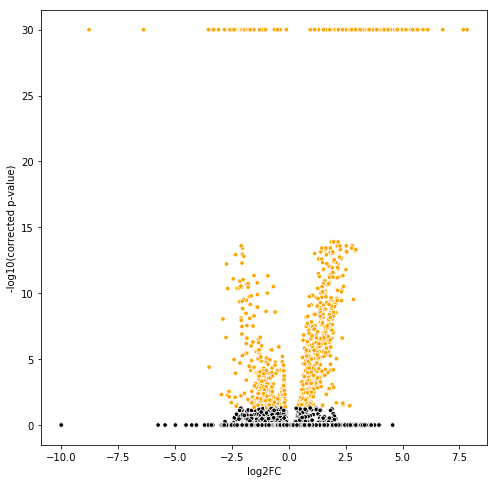

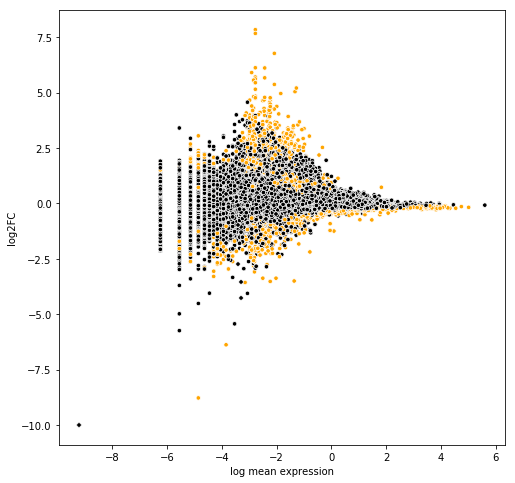

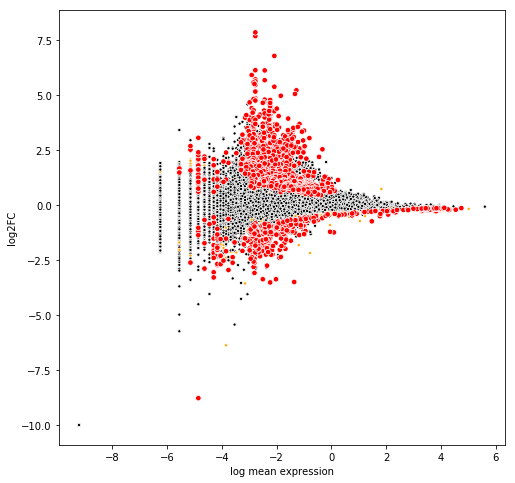

Cluster NSC2 fate:


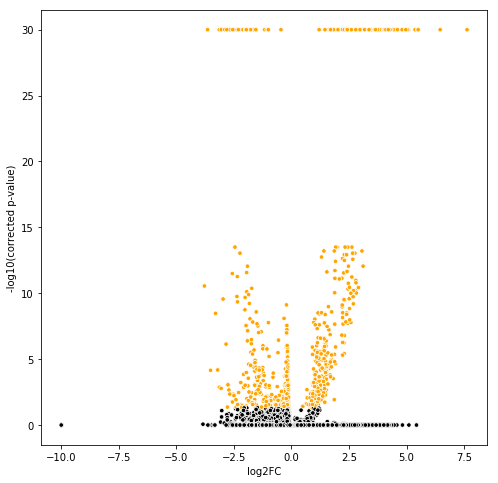

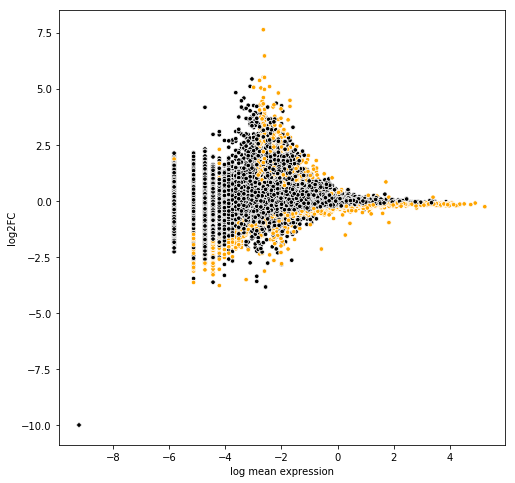

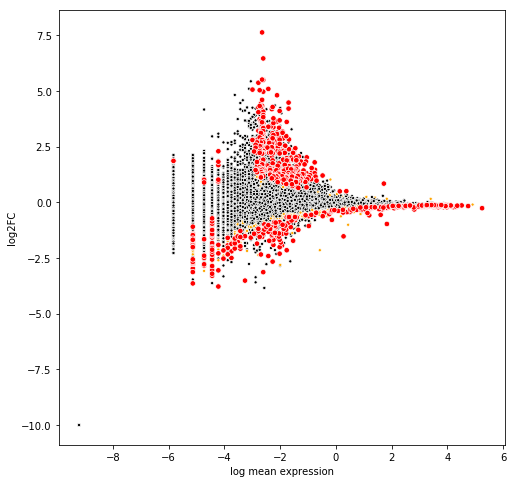

In [27]:
for clust in de_results_clusts:
    print(f'Cluster {clust}:')
    de_results_clusts[clust].plot_volcano()
    de_results_clusts[clust].plot_ma()
    de_results_clusts[clust].plot_ma(size=10, highlight_ids = np.asarray(de_full_res_clusts[clust]['gene'][de_full_res_clusts[clust]['qval'] < 0.05]))


Cluster True:


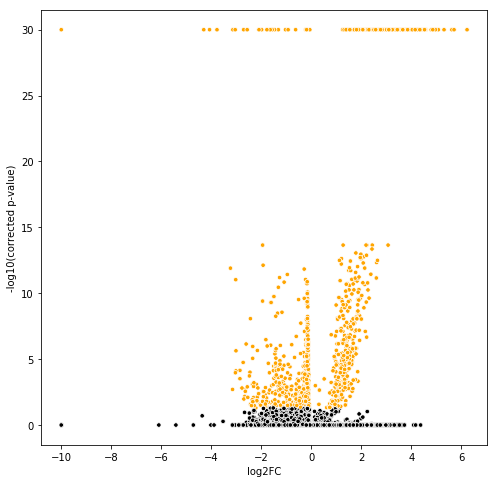

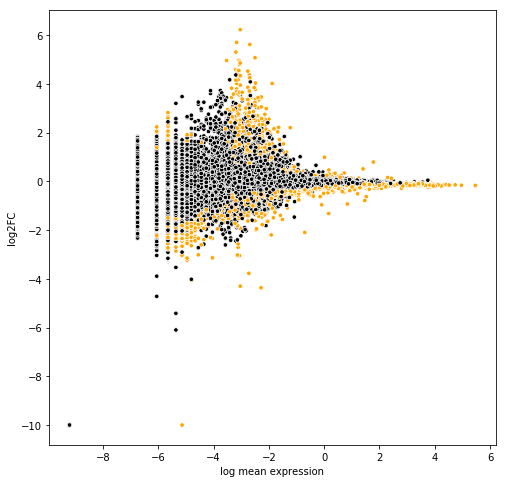

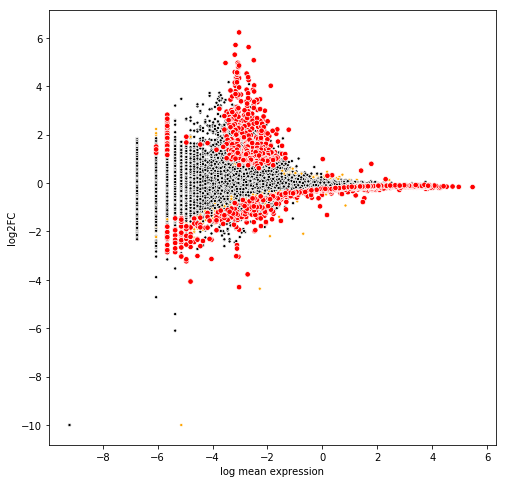

In [28]:
for clust in de_results:
    print(f'Cluster {clust}:')
    de_results[clust].plot_volcano()
    de_results[clust].plot_ma()
    de_results[clust].plot_ma(size=10, highlight_ids = np.asarray(de_full_res[clust]['gene'][de_full_res[clust]['qval'] < 0.05]))


## Enrichment analysis

In [29]:
# Plotting functions - 'GProfiler-official version'
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from matplotlib import colors
from matplotlib import rcParams


def scale_data_5_75(data):
    mind = np.min(data)
    maxd = np.max(data)
    
    if maxd == mind:
        maxd=maxd+1
        mind=mind-1
        
    drange = maxd - mind
    return ((((data - mind)/drange*0.70)+0.05)*100)


def plot_enrich(data, n_terms=20, save=False):
    # Test data input
    if not isinstance(data, pd.DataFrame):
        raise ValueError('Please input a Pandas Dataframe output by gprofiler.')
        
    if not np.all([term in data.columns for term in ['p_value', 'name', 'intersection_size']]):
        raise TypeError('The data frame {} does not contain enrichment results from gprofiler.'.format(data))
    
    data_to_plot = data.iloc[:n_terms,:].copy()
    data_to_plot['go.id'] = data_to_plot.index

    min_pval = data_to_plot['p_value'].min()
    max_pval = data_to_plot['p_value'].max()
    
    # Scale intersection_size to be between 5 and 75 for plotting
    #Note: this is done as calibration was done for values between 5 and 75
    data_to_plot['scaled.overlap'] = scale_data_5_75(data_to_plot['intersection_size'])
    
    norm = colors.LogNorm(min_pval, max_pval)
    sm = plt.cm.ScalarMappable(cmap="cool", norm=norm)
    sm.set_array([])

    rcParams.update({'font.size': 14, 'font.weight': 'bold'})

    sb.set(style="whitegrid")

    path = plt.scatter(x='recall', y="name", c='p_value', cmap='cool', 
                       norm=colors.LogNorm(min_pval, max_pval), 
                       data=data_to_plot, linewidth=1, edgecolor="grey", 
                       s=[(i+10)**1.5 for i in data_to_plot['scaled.overlap']])
    ax = plt.gca()
    ax.invert_yaxis()

    ax.set_ylabel('')
    ax.set_xlabel('Gene ratio', fontsize=14, fontweight='bold')
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)

    # Shrink current axis by 20%
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    # Get tick marks for this plot
    #Note: 6 ticks maximum
    min_tick = np.floor(np.log10(min_pval)).astype(int)
    max_tick = np.ceil(np.log10(max_pval)).astype(int)
    tick_step = np.ceil((max_tick - min_tick)/6).astype(int)
    
    # Ensure no 0 values
    if tick_step == 0:
        tick_step = 1
        min_tick = max_tick-1
    
    ticks_vals = [10**i for i in range(max_tick, min_tick-1, -tick_step)]
    ticks_labs = ['$10^{'+str(i)+'}$' for i in range(max_tick, min_tick-1, -tick_step)]

    #Colorbar
    fig = plt.gcf()
    cbaxes = fig.add_axes([0.8, 0.15, 0.03, 0.4])
    cbar = ax.figure.colorbar(sm, ticks=ticks_vals, shrink=0.5, anchor=(0,0.1), cax=cbaxes)
    cbar.ax.set_yticklabels(ticks_labs)
    cbar.set_label("Adjusted p-value", fontsize=14, fontweight='bold')

    #Size legend
    min_olap = data_to_plot['intersection_size'].min()
    max_olap = data_to_plot['intersection_size'].max()
    olap_range = max_olap - min_olap
    
    #Note: approximate scaled 5, 25, 50, 75 values are calculated
    #      and then rounded to nearest number divisible by 5
    size_leg_vals = [np.round(i/5)*5 for i in 
                          [min_olap, min_olap+(20/70)*olap_range, min_olap+(45/70)*olap_range, max_olap]]
    size_leg_scaled_vals = scale_data_5_75(size_leg_vals)

    
    l1 = plt.scatter([],[], s=(size_leg_scaled_vals[0]+10)**1.5, edgecolors='none', color='black')
    l2 = plt.scatter([],[], s=(size_leg_scaled_vals[1]+10)**1.5, edgecolors='none', color='black')
    l3 = plt.scatter([],[], s=(size_leg_scaled_vals[2]+10)**1.5, edgecolors='none', color='black')
    l4 = plt.scatter([],[], s=(size_leg_scaled_vals[3]+10)**1.5, edgecolors='none', color='black')

    labels = [str(int(i)) for i in size_leg_vals]

    leg = plt.legend([l1, l2, l3, l4], labels, ncol=1, frameon=False, fontsize=12,
                     handlelength=1, loc = 'center left', borderpad = 1, labelspacing = 1.4,
                     handletextpad=2, title='Gene overlap', scatterpoints = 1,  bbox_to_anchor=(-2, 1.5), 
                     facecolor='black')

    if save:
        plt.savefig(save, dpi=300, format='pdf')

    plt.show()

### Biological Process GO Term enrichment

Background genes for DE testing was changed from genes actually tested to annotated genes. Often there are fewer annotated genes than ones we are testing over. We should actually use the annotated and tested genes as background, but this is currently not possible in gprofiler-official.

In [30]:
gp = GProfiler(return_dataframe=True, user_agent='g:GOSt')

In [31]:
de_gobp_enrich_clusts = dict()

for clust in de_signif_clusts:
    tmp = gp.profile(organism='hsapiens', sources=['GO:BP'], user_threshold=0.05,
                               significance_threshold_method='fdr', 
                               domain_scope='annotated', 
                               query=de_signif_clusts[clust]['gene'].tolist())
    
    if tmp is not None:
        tmp.set_index('native', inplace=True)
        de_gobp_enrich_clusts[clust] = tmp.sort_values('p_value').iloc[:,[2,5,7,10,1]]
    else:
        de_gobp_enrich_clusts[clust] = pd.DataFrame()
    
    # Print some results
    print(f'Cluster {clust}:')
    de_gobp_enrich_clusts[clust].iloc[:50,:]

Cluster NSC1 fate:


,p_value,term_size,intersection_size,recall,name
native,,,,,
GO:0006614,1.948228e-36,96,51,0.531250,SRP-dependent cotranslational protein targetin...
GO:0045047,3.617093e-35,111,53,0.477477,protein targeting to ER
GO:0006613,3.617093e-35,102,51,0.500000,cotranslational protein targeting to membrane
GO:0072599,2.050877e-34,115,53,0.460870,establishment of protein localization to endop...
GO:0000184,1.760268e-31,123,52,0.422764,"nuclear-transcribed mRNA catabolic process, no..."
GO:0002181,8.589894e-30,149,55,0.369128,cytoplasmic translation
GO:0019083,1.045140e-29,181,60,0.331492,viral transcription
GO:0070972,1.091820e-28,144,53,0.368056,protein localization to endoplasmic reticulum
GO:0006612,1.715116e-26,219,62,0.283105,protein targeting to membrane


Cluster NSC2 fate:


,p_value,term_size,intersection_size,recall,name
native,,,,,
GO:0006614,4.742756e-81,96,68,0.708333,SRP-dependent cotranslational protein targetin...
GO:0006613,2.055032e-78,102,68,0.666667,cotranslational protein targeting to membrane
GO:0045047,1.523445e-76,111,69,0.621622,protein targeting to ER
GO:0072599,4.396891e-75,115,69,0.600000,establishment of protein localization to endop...
GO:0000184,7.129041e-69,123,67,0.544715,"nuclear-transcribed mRNA catabolic process, no..."
GO:0070972,1.626210e-67,144,70,0.486111,protein localization to endoplasmic reticulum
GO:0019083,3.758487e-63,181,73,0.403315,viral transcription
GO:0002181,1.115021e-61,149,67,0.449664,cytoplasmic translation
GO:0006612,1.829921e-61,219,77,0.351598,protein targeting to membrane


In [32]:
de_gobp_enrich = dict()

for clust in de_signif:
    tmp = gp.profile(organism='hsapiens', sources=['GO:BP'], user_threshold=0.05,
                               significance_threshold_method='fdr', 
                               domain_scope='annotated', 
                               query=de_signif[clust]['gene'].tolist())
    
    if tmp is not None:
        tmp.set_index('native', inplace=True)
        de_gobp_enrich[clust] = tmp.sort_values('p_value').iloc[:,[2,5,7,10,1]]
    else:
        de_gobp_enrich[clust] = pd.DataFrame()
    
    # Print some results
    print(f'Cluster {clust}:')
    de_gobp_enrich[clust].iloc[:50,:]

Cluster True:


,p_value,term_size,intersection_size,recall,name
native,,,,,
GO:0006614,7.171665e-94,96,81,0.843750,SRP-dependent cotranslational protein targetin...
GO:0006613,7.106946e-90,102,81,0.794118,cotranslational protein targeting to membrane
GO:0045047,2.278980e-88,111,83,0.747748,protein targeting to ER
GO:0072599,2.829588e-86,115,83,0.721739,establishment of protein localization to endop...
GO:0070972,2.109541e-75,144,84,0.583333,protein localization to endoplasmic reticulum
GO:0000184,5.095134e-74,123,78,0.634146,"nuclear-transcribed mRNA catabolic process, no..."
GO:0002181,2.529306e-66,149,79,0.530201,cytoplasmic translation
GO:0006612,5.270346e-66,219,92,0.420091,protein targeting to membrane
GO:0019083,3.315831e-63,181,83,0.458564,viral transcription


Cluster: NSC1 fate


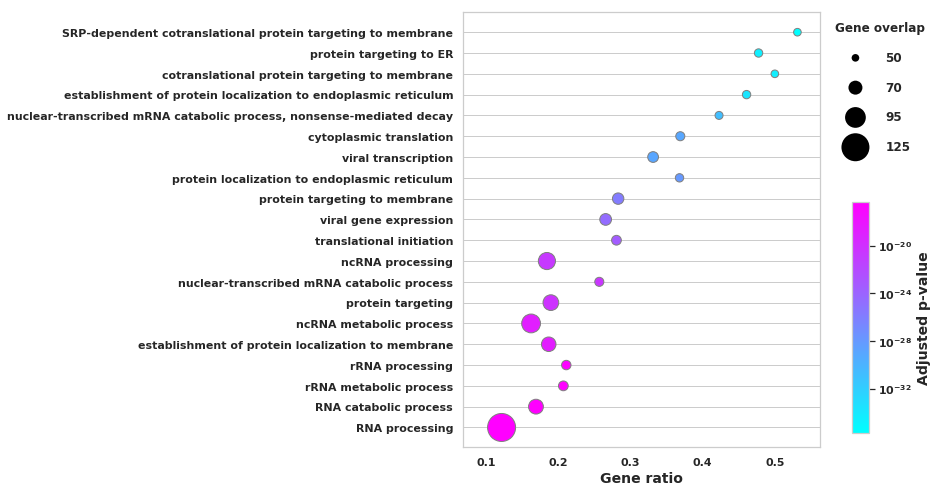

Cluster: NSC2 fate


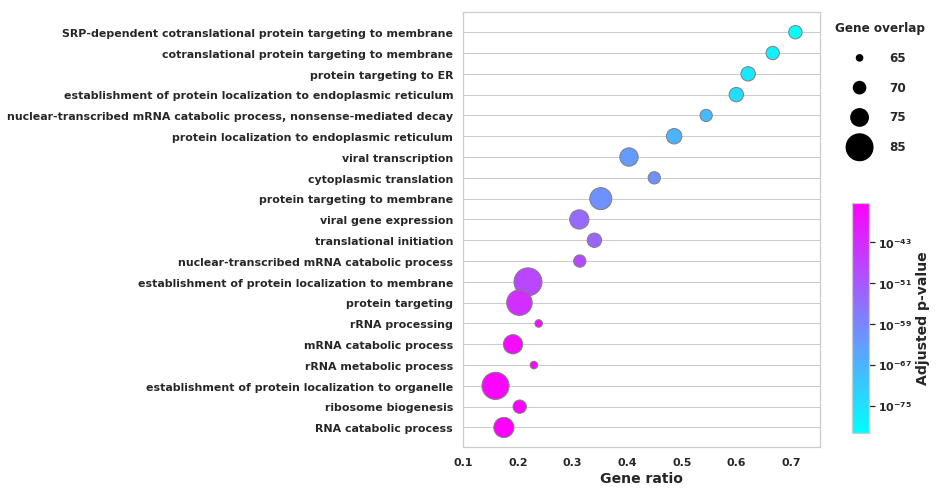

In [33]:
for clust in de_gobp_enrich_clusts:
    # Plot the results
    print(f'Cluster: {clust}')
    if len(de_gobp_enrich_clusts[clust].columns) > 0:
        plot_enrich(de_gobp_enrich_clusts[clust])

Cluster: True


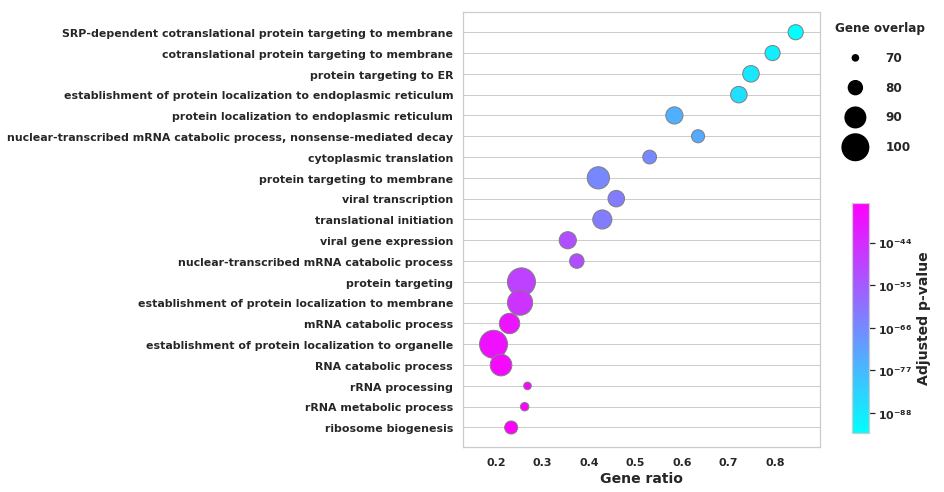

In [34]:
for clust in de_gobp_enrich:
    # Plot the results
    print(f'Cluster: {clust}')
    if len(de_gobp_enrich[clust].columns) > 0:
        plot_enrich(de_gobp_enrich[clust])

### KEGG Pathway enrichment

In [35]:
de_pathway_enrich_clusts = dict()

for clust in de_signif_clusts:
    tmp = gp.profile(organism='hsapiens', sources=['KEGG', 'REAC'], user_threshold=0.05,
                               significance_threshold_method='fdr', 
                               domain_scope='annotated', 
                               query=de_signif_clusts[clust]['gene'].tolist())
    
    if tmp is not None:
        tmp.set_index('native', inplace=True)
        de_pathway_enrich_clusts[clust] = tmp.sort_values('p_value').iloc[:,[2,5,7,10,1]]
    else:
        de_pathway_enrich_clusts[clust] = pd.DataFrame()
    
    # Print some results
    print(f'Cluster {clust}:')
    de_pathway_enrich_clusts[clust].iloc[:50,:]

Cluster NSC1 fate:


,p_value,term_size,intersection_size,recall,name
native,,,,,
REAC:R-HSA-156902,1.841661e-39,90,52,0.577778,Peptide chain elongation
REAC:R-HSA-156842,1.547759e-38,94,52,0.553191,Eukaryotic Translation Elongation
REAC:R-HSA-192823,1.547759e-38,90,51,0.566667,Viral mRNA Translation
REAC:R-HSA-72764,1.874448e-37,94,51,0.542553,Eukaryotic Translation Termination
REAC:R-HSA-2408557,1.874448e-37,94,51,0.542553,Selenocysteine synthesis
REAC:R-HSA-975956,6.502530e-37,96,51,0.531250,Nonsense Mediated Decay (NMD) independent of t...
REAC:R-HSA-9633012,2.691582e-35,102,51,0.500000,Response of EIF2AK4 (GCN2) to amino acid defic...
REAC:R-HSA-72689,2.691582e-35,102,51,0.500000,Formation of a pool of free 40S subunits
REAC:R-HSA-156827,9.049768e-33,112,51,0.455357,L13a-mediated translational silencing of Cerul...


Cluster NSC2 fate:


,p_value,term_size,intersection_size,recall,name
native,,,,,
REAC:R-HSA-156842,3.059430e-78,94,68,0.723404,Eukaryotic Translation Elongation
REAC:R-HSA-156902,3.059430e-78,90,67,0.744444,Peptide chain elongation
REAC:R-HSA-192823,1.138591e-76,90,66,0.733333,Viral mRNA Translation
REAC:R-HSA-2408557,1.356272e-76,94,67,0.712766,Selenocysteine synthesis
REAC:R-HSA-72764,9.107980e-75,94,66,0.702128,Eukaryotic Translation Termination
REAC:R-HSA-975956,7.527646e-74,96,66,0.687500,Nonsense Mediated Decay (NMD) independent of t...
REAC:R-HSA-9633012,5.789821e-73,102,67,0.656863,Response of EIF2AK4 (GCN2) to amino acid defic...
REAC:R-HSA-72689,3.305239e-71,102,66,0.647059,Formation of a pool of free 40S subunits
REAC:R-HSA-1799339,1.447980e-68,113,67,0.592920,SRP-dependent cotranslational protein targetin...


In [36]:
de_pathway_enrich = dict()

for clust in de_signif:
    tmp = gp.profile(organism='hsapiens', sources=['KEGG', 'REAC'], user_threshold=0.05,
                               significance_threshold_method='fdr', 
                               domain_scope='annotated', 
                               query=de_signif[clust]['gene'].tolist())
    
    if tmp is not None:
        tmp.set_index('native', inplace=True)
        de_pathway_enrich[clust] = tmp.sort_values('p_value').iloc[:,[2,5,7,10,1]]
    else:
        de_pathway_enrich[clust] = pd.DataFrame()
    
    # Print some results
    print(f'Cluster {clust}:')
    de_pathway_enrich[clust].iloc[:50,:]

Cluster True:


,p_value,term_size,intersection_size,recall,name
native,,,,,
REAC:R-HSA-156902,1.454928e-93,90,80,0.888889,Peptide chain elongation
REAC:R-HSA-156842,1.371234e-92,94,81,0.861702,Eukaryotic Translation Elongation
REAC:R-HSA-72764,1.255130e-90,94,80,0.851064,Eukaryotic Translation Termination
REAC:R-HSA-192823,9.743290e-90,90,78,0.866667,Viral mRNA Translation
REAC:R-HSA-2408557,9.508168e-89,94,79,0.840426,Selenocysteine synthesis
REAC:R-HSA-975956,2.448161e-87,96,79,0.822917,Nonsense Mediated Decay (NMD) independent of t...
REAC:R-HSA-72689,2.190178e-83,102,79,0.774510,Formation of a pool of free 40S subunits
REAC:R-HSA-1799339,1.261892e-82,113,82,0.725664,SRP-dependent cotranslational protein targetin...
REAC:R-HSA-9633012,1.323256e-81,102,78,0.764706,Response of EIF2AK4 (GCN2) to amino acid defic...


Cluster: NSC1 fate


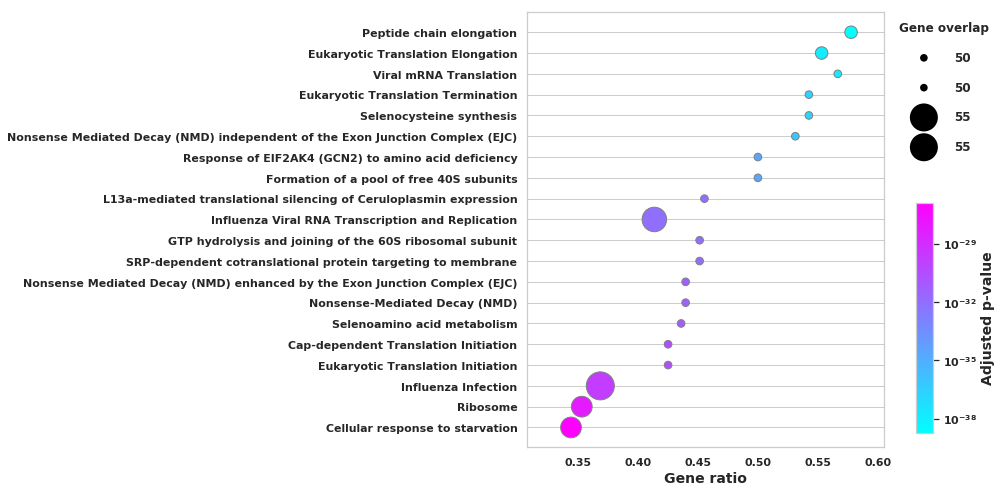

Cluster: NSC2 fate


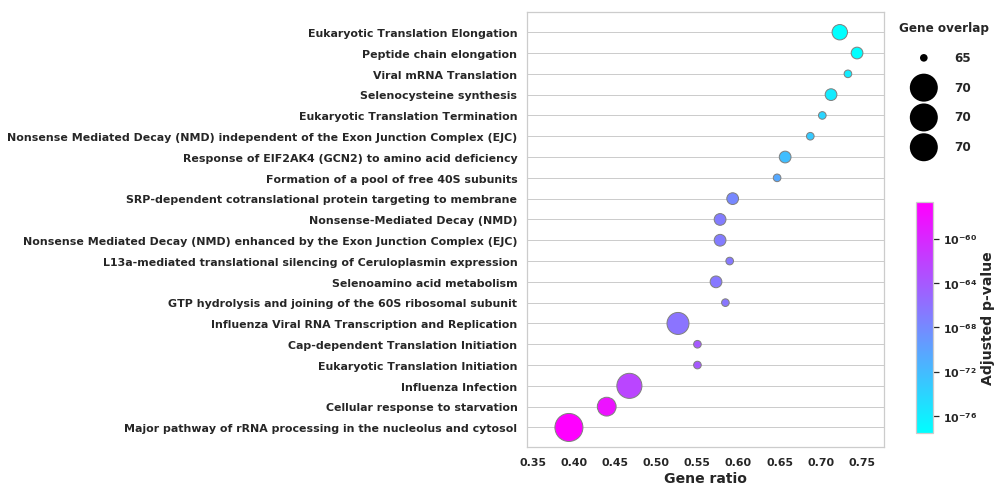

In [37]:
for clust in de_pathway_enrich_clusts:
    # Plot the results
    print(f'Cluster: {clust}')
    if len(de_pathway_enrich_clusts[clust].columns) > 0:
        plot_enrich(de_pathway_enrich_clusts[clust])

Cluster: True


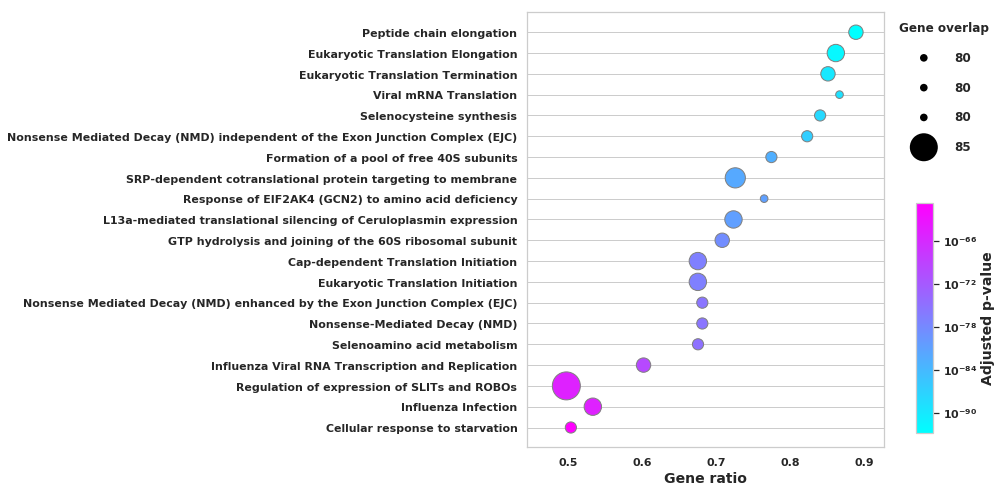

In [38]:
for clust in de_pathway_enrich:
    # Plot the results
    print(f'Cluster: {clust}')
    if len(de_pathway_enrich[clust].columns) > 0:
        plot_enrich(de_pathway_enrich[clust])

# Check individual gene

### Foxa2

In [39]:
goi = 'FOXA2'

for clust in de_results:
    print(f'Cluster {clust}:')
    tmp2 = de_results[clust].summary()
    if goi in tmp2['gene'].values:
        tmp2.query('gene == "'+goi+'"')
    else:
        print(f'Gene {goi} was not tested for Cluster {clust}.')
        print('')

Cluster True:


,gene,pval,qval,log2fc,mean,zero_mean,grad,coef_mle,coef_sd,ll
19390,FOXA2,0.401764,1.0,-0.241076,0.213615,False,0.058502,-0.241076,0.287517,-427.7775


In [40]:
goi = 'FOXA2'

for clust in de_results_clusts:
    print(f'Cluster {clust}:')
    tmp2 = de_results_clusts[clust].summary()
    if goi in tmp2['gene'].values:
        tmp2.query('gene == "'+goi+'"')
    else:
        print(f'Gene {goi} was not tested for Cluster {clust}.')
        print('')

Cluster NSC1 fate:


,gene,pval,qval,log2fc,mean,zero_mean,grad,coef_mle,coef_sd,ll
18319,FOXA2,0.600699,1.0,-0.491646,0.237354,False,0.054928,-0.491646,0.939339,-276.87236


Cluster NSC2 fate:


,gene,pval,qval,log2fc,mean,zero_mean,grad,coef_mle,coef_sd,ll
18075,FOXA2,0.655706,1.0,-0.546737,0.177515,False,0.037344,-0.546737,1.226281,-141.467289


Interesting that FOXA2 is up-regulated on the bulk-like analysis, but not in any individual cell cluster. Perhaps there is not sufficient power in any cluster to find it significantly up-regulated.

# Save data

In [41]:
import pickle

In [42]:
#Pickle the de output
pickle.dump(de_results_clusts, open(de_output_pickle_clusts, "wb"))

In [43]:
#Pickle the de output
pickle.dump(de_results, open(de_output_pickle, "wb"))

In [44]:
#Output individual results
for clust in de_signif_clusts:
    
    filename_signif = de_output_base+'_clusts_significant005_'+clust.replace(' ', '_').replace(
        '/','_').replace('(','').replace(')','')+'.csv'
    filename_full = de_output_base+'_clusts_full_'+clust.replace(' ', '_').replace(
        '/','_').replace('(','').replace(')','')+'.csv'
    
    de_signif_clusts[clust].iloc[:,[0,2,3,4,8]].to_csv(filename_signif)
    de_full_res_clusts[clust].iloc[:,[0,2,3,4,8]].to_csv(filename_full)

In [45]:
#Output individual results
for clust in de_signif:
    clust_str = str(clust)
    
    filename_signif = de_output_base+'_significant005_'+clust_str.replace(' ', '_').replace(
        '/','_').replace('(','').replace(')','')+'.csv'
    filename_full = de_output_base+'_full_'+clust_str.replace(' ', '_').replace(
        '/','_').replace('(','').replace(')','')+'.csv'
    
    de_signif[clust].iloc[:,[0,2,3,4,8]].to_csv(filename_signif)
    de_full_res[clust].iloc[:,[0,2,3,4,8]].to_csv(filename_full)

# Output enrichment data

In [46]:
#Output enrichment results per cluster
for clust in de_gobp_enrich_clusts:
    fn_base = enrich_output_base+'_clusts_'+clust.replace(' ', '_').replace(
        '/','_').replace('(','').replace(')','')

    if de_gobp_enrich_clusts[clust].shape != (0,0):
        de_gobp_enrich_clusts[clust].to_csv(fn_base+'_gobp.csv')

    if de_pathway_enrich_clusts[clust].shape != (0,0):
        de_pathway_enrich_clusts[clust].to_csv(fn_base+'_pathway.csv')

In [47]:
#Output enrichment results per cluster
for clust in de_gobp_enrich:
    clust_str = str(clust)
    
    fn_base = enrich_output_base+'_'+clust_str.replace(' ', '_').replace(
        '/','_').replace('(','').replace(')','')

    if de_gobp_enrich[clust].shape != (0,0):
        de_gobp_enrich[clust].to_csv(fn_base+'_gobp.csv')

    if de_pathway_enrich[clust].shape != (0,0):
        de_pathway_enrich[clust].to_csv(fn_base+'_pathway.csv')